# Analyzing the Titanic dataset

Here we will perform an analysis of the [Kaggle Titanic dataset](https://www.kaggle.com/c/titanic/data) concerned with the passengers involved in the [RMS Titanic](https://en.wikipedia.org/wiki/RMS_Titanic) iceberg collision disaster April 14th to 15th, 1912.

First we load up the dataset and take a look at the raw data in order to get an understanding about the kind of data we're dealing with. Knowing the kind and shape of the available data will allow us to come up with questions we can ask about the dataset, as well as strategies to prepare the data for the analysis.

In [1]:
import pandas as pd
titanic = pd.read_csv('titanic-data.csv')
titanic = titanic.set_index('PassengerId')
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The dataset consists of about 900 entries.

In [2]:
len(titanic)

891

The columns are encoded as follows:
* `PassengerId` is a unique ID for each passenger,
* `Survived` is a binary value encoding if the passenger survived (`1`) or died in the accident (`0`),
* `Pclass` represents the ticket class in range `1..3`, with `1` representing 1st class, etc.,
* `Name` gives the name of the passenger,
* `Sex` the sex,
* `Age` the age, with the value being fractional if less than `1.0` or estimated,
* `SibSp` gives the number of siblings or spouses aboard the ship,
* `Parch` gives the number of parents or children aboard the ship,
* `Ticket` represents the ticket number,
* `Fare` the passenger fare,
* `Cabin` the cabin number, and
* `Embarked` the port of embarkation, with `C` representing Cherbourg, `Q` for Queenstown and `S` for Southhampton.

For `SibSp`, the definition of _sibling_ is brother, sister, stepbrother or stepsister, where _spouse_ means husband or wife, with mistresses and fiancés not being represented. 
For `Parch`, _parent_ means mother or father, where _child_ means daughter, son, stepdaughter or stepson. Children travelling only with a Nanny will thus have a value of `0` in this column.

The value of `Pclass` can furthermore be taken as a proxy for the socio-economic status of the passenger, with a 1st class ticket (`1`) encoding upper class, whereas a 3rd class ticket (`3`) represents lower class status.

## Questions to be asked

The obvious question for a ship accident is if [Women and children first](https://en.wikipedia.org/wiki/Women_and_children_first) indeed holds for the passenger of the Titanic. If so, we would expect to see a higher number of women and children having survived the accident than men. Additionally we might be interested in seeing if a higher social-economic status (or ticket class, for that matter), correlates with survivorship - and lastly, if there is a skew in the classes of children and women towards ticket class.
The initial overview shows to cases of women names containing `Miss` or `Mrs.`, indicating marriage status. Maybe unmarried women were more likely to survive, because they were younger? Were they? Generally, does age correlate with survivorship?

A somewhat silly, but similar question is if the Titanics captain, [Edward Smith](https://en.wikipedia.org/wiki/Edward_Smith_&#40;sea_captain&#41;), did sink with his ship, which can be easily determined if his name is represented in the list of "passengers". We do, however, already know from reports he was in the vicinity of, but not on the bridge five minutes before the ship disappered beneath the ocean and that his body was never discovered.

The cabin number might correlate with survivorship, depending on where in the Titanic the cabin was located. This information might be even more helpful when correlated with knowledge about ongoing events aboard the ship and their locations. These questions, however, cannot be answered from this dataset alone. Since the accident happened at 23:40h ship time (UTC -3:27h), the assumption that people were in their cabins might hold, thus we might be able to correlate deck names or cabin numbers with survivorship.
However, even if people made it to the lifeboats, survivorship should still be dependent on the time it took for rescue to arrive given the circumstances.

The ticket number appears unlikely to be of use since it does not seem to be uniform. However, [this thread](https://www.kaggle.com/c/titanic/discussion/11127) suggests that identical ticket numbers can be used to determine shared cabin usage (for when no cabin information is present) or joint ticket usage.

We might be able to find other relationships between survivorship and available variables by examining statistics conditioned on the recorded survivorship.

## Cabin allocations

According to [Ecyclopedia Titanica](https://www.encyclopedia-titanica.org/cabins.html), the cabin allocations
were obtained from an incomplete first class passenger list recovered with the body of one of the stewards, Herbert Cave. The first letter in the `Cabin` field encodes the deck, where `A` represents the topmost and `G` the bottommost deck. The complete deckplans can be found [here](https://www.encyclopedia-titanica.org/titanic-deckplans/).


![](images/Titanic_cutaway_diagram.png)



We know that the Titanic rammed the iceberg near the bow, which resulted in the ship sinking "heads first". From the deck plan it appears that most 1st class areas were assigned to the front half of the ship, which could imply that passengers assigned to cabins in these areas have a lower survivorship recorded.


# Assessing data quality

We first validate if the column data is actually in the format we expect.

### Survirorship

There are indeed two distinct values for the `Survivor` column, so we change this column to be boolean.

In [3]:
titanic['Survived'].unique()

array([0, 1])

In [4]:
titanic['Survived'] = titanic['Survived'].astype(bool).astype('category')
titanic['Survived'].unique()

[False, True]
Categories (2, object): [False, True]

### Ticket class

Similarly the ticket class contains only the expected values `1..3`. We turn it into a categorical variable as well.

In [5]:
titanic['Pclass'].unique()

array([3, 1, 2])

In [6]:
import numpy as np
titanic['Pclass'] = titanic['Pclass'].astype(np.uint8).astype('category')
titanic['Pclass'].unique()

[3, 1, 2]
Categories (3, uint64): [3, 1, 2]

### Sex

The passenger's sex does not show unexpected values and is converted to a categorical value.

In [7]:
titanic['Sex'].unique()

array(['male', 'female'], dtype=object)

In [8]:
import numpy as np
titanic['Sex'] = titanic['Sex'].astype(str).astype('category')
titanic['Sex'].unique()

[male, female]
Categories (2, object): [male, female]

### Passenger name

Out of curiosity, we check if the number of distinct passenger names is equal to the length of the list. That appears to be the case, so no (obvious) duplications exist in the dataset.

In [9]:
len(titanic['Name'].unique()) - len(titanic['Name'])

0

Let's check if captain Edward Smith appears in the dataset:

In [10]:
titanic.loc[titanic['Name'].apply(lambda name: 'Smith' in name)]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
175,False,1,"Smith, Mr. James Clinch",male,56.0,0,0,17764,30.6958,A7,C
261,False,3,"Smith, Mr. Thomas",male,NaN,0,0,384461,7.7500,NaN,Q
285,False,1,"Smith, Mr. Richard William",male,NaN,0,0,113056,26.0000,A19,S
347,True,2,"Smith, Miss. Marion Elsie",female,40.0,0,0,31418,13.0000,NaN,S


It turns out he doesn't (unless there is a typo in the name). Likewise, Herbert Cave, from whom the cabin assignment list was retrieved, does not appear in the dataset:

In [11]:
titanic.loc[titanic['Name'].apply(lambda name: 'Cave' in name)]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
742,False,1,"Cavendish, Mr. Tyrell William",male,36.0,1,0,19877,78.85,C46,S


This makes clear the dataset indeed only appears to represent _passengers_ aboard the Titanic, not every person.

Let's make sure every name field has exactly one comma in it by counting how many names cannot be split in exactly two groups:

In [12]:
len(titanic.loc[titanic['Name'].apply(lambda name: len(name.split(',')) != 2)])

0

Since we know for sure we can split each name into exactly two values and the family name appears to be the first piece, let's split them:

In [13]:
titanic['LastName'] = titanic['Name'].apply(lambda name: name.split(',')[0].strip())
titanic['FirstName'] = titanic['Name'].apply(lambda name: name.split(',')[1].strip())
del titanic['Name']

titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LastName,FirstName
PassengerId,,,,,,,,,,,,
1,False,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,Mr. Owen Harris
2,True,1,female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,Mrs. John Bradley (Florence Briggs Thayer)
3,True,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,Miss. Laina
4,True,1,female,35.0,1,0,113803,53.1000,C123,S,Futrelle,Mrs. Jacques Heath (Lily May Peel)
5,False,3,male,35.0,0,0,373450,8.0500,NaN,S,Allen,Mr. William Henry


While we're at it, let's also look at the _Mrs._, _Miss_ and _Ms._ indictors:

In [14]:
titanic[titanic['Sex'] == 'female']['FirstName'].apply(lambda name: name.split()[0]).value_counts()

Miss.    182
Mrs.     125
Mlle.      2
Lady.      1
the        1
Ms.        1
Mme.       1
Dr.        1
Name: FirstName, dtype: int64

It appears there are the representations [_Miss._](https://en.wikipedia.org/wiki/Miss) and [_Mlle._](https://en.wikipedia.org/wiki/Mademoiselle_&#40;title&#41;) for unmarried women, as well as [_Mrs._](https://en.wikipedia.org/wiki/Mrs.) and _Mme._ for married women. _Ms._ is no clear indicator and the cases `Lady.`, `the` and `Dr.` would require to be investigated further. Since each of these only occurs once, we decide to simply drop these values.

In [15]:
def woman_marriage_status(name):
    if 'Miss.' in name or 'Mlle.' in name:
        return False
    if 'Mrs.' in name or 'Mme.' in name:
        return True
    return float('NaN')

titanic['MarriedWoman'] = titanic['FirstName'].apply(woman_marriage_status)
titanic[['Sex', 'FirstName', 'MarriedWoman']].head()

,Sex,FirstName,MarriedWoman
PassengerId,,,
1,male,Mr. Owen Harris,NaN
2,female,Mrs. John Bradley (Florence Briggs Thayer),True
3,female,Miss. Laina,False
4,female,Mrs. Jacques Heath (Lily May Peel),True
5,male,Mr. William Henry,NaN


### Age

All of the values in the list appear to be convertible to `float`, which also includes `NaN` values.

In [16]:
import math
def is_valid_float(value, allow_nan=False):
  try:
    f = float(value)
    return allow_nan or not math.isnan(f)
  except ValueError:
    return False

In [17]:
titanic['Age'].apply(lambda x: is_valid_float(x, allow_nan=True)).unique()

array([ True], dtype=bool)

There are `714` passengers who do have a recorded age and `177` passengers for which no age information is present.

In [18]:
titanic['Age'].apply(lambda x: is_valid_float(x, allow_nan=False)).value_counts()

True     714
False    177
Name: Age, dtype: int64

In [19]:
titanic['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

### Siblings and spouses

No unexpected data is in the `SibSp` column.

In [20]:
titanic['SibSp'].unique()

array([1, 0, 3, 4, 2, 5, 8])

### Parents and children

Same goes for the `Parch` column.

In [21]:
titanic['Parch'].unique()

array([0, 1, 2, 5, 3, 4, 6])

### Ticket

Let's have a look at the structure of the `Ticket` column:

In [22]:
titanic['Ticket'].head()

PassengerId
1           A/5 21171
2            PC 17599
3    STON/O2. 3101282
4              113803
5              373450
Name: Ticket, dtype: object

It appears that we might be able to split the ticket number into an optional prefix and a numerical value. Let's see if this assumption holds:

In [23]:
titanic['Ticket'].apply(lambda x: len(x.split())).value_counts()

1    665
2    213
3     13
Name: Ticket, dtype: int64

Apparently there are 13 ticket numbers that have more than two fields. Let's look them up:

In [24]:
show = ['Sex', 'Ticket', 'Fare', 'Embarked', 'LastName', 'FirstName']

splits = titanic['Ticket'].apply(lambda x: len(x.split()))
titanic[splits == 3].sort_values('Ticket')[show]

,Sex,Ticket,Fare,Embarked,LastName,FirstName
PassengerId,,,,,,
474,female,SC/AH Basle 541,13.7917,C,Jerwan,Mrs. Amin S (Marie Marthe Thuillard)
415,male,STON/O 2. 3101269,7.9250,S,Sundman,Mr. Johan Julian
591,male,STON/O 2. 3101273,7.1250,S,Rintamaki,Mr. Matti
434,male,STON/O 2. 3101274,7.1250,S,Kallio,Mr. Nikolai Erland
244,male,STON/O 2. 3101275,7.1250,S,Maenpaa,Mr. Matti Alexanteri
174,male,STON/O 2. 3101280,7.9250,S,Sivola,Mr. Antti Wilhelm
665,male,STON/O 2. 3101285,7.9250,S,Lindqvist,Mr. Eino William
580,male,STON/O 2. 3101286,7.9250,S,Jussila,Mr. Eiriik
745,male,STON/O 2. 3101288,7.9250,S,Stranden,Mr. Juho


According to [this report](https://www.encyclopedia-titanica.org/titanic-survivor/marie-marthe-jerwan.html), Mrs. Marie Jerwan had ticket number `541`. Similarly, [Mr. Eiriik Jussilas](https://www.encyclopedia-titanica.org/titanic-survivor/eiriik-jussila.html) ticket number is reported as `3101286`. We can thus assume that only the last split encodes the actual ticket number, with everything else being a prefix.

In [25]:
titanic['TicketNumber'] = titanic['Ticket'].apply(lambda x: x.split()[-1].strip())
titanic['TicketPrefix'] = titanic['Ticket'].apply(lambda x: ' '.join(x.split()[:-1]).strip()).astype('category')
del titanic['Ticket']

A check on the extracted ticket numbers shows that not all values are indeed numerical:

In [26]:
def is_valid_int(x):
    try:
        int(x)
        return True
    except ValueError:
        return False

titanic['TicketNumber'].apply(is_valid_int).value_counts()

True     887
False      4
Name: TicketNumber, dtype: int64

Let's bring them up:

In [27]:
titanic[~titanic['TicketNumber'].apply(is_valid_int)]['TicketNumber']

PassengerId
180    LINE
272    LINE
303    LINE
598    LINE
Name: TicketNumber, dtype: object

In all these cases, the ticket is registered as `LINE`. We can find from [this report](https://www.encyclopedia-titanica.org/titanic-survivor/william-henry-tornquist.html) that the ticket numbers of Lionel Törnquist, Alfred Johnson and William Johnson is actually `370160`. Lionel Leonard's real name was [Andrew John Shannon](https://www.encyclopedia-titanica.org/titanic-victim/lionel-leonard.html) and he too was travelling on the same ticket number, `370160`.

We will manually fix these values:

In [28]:
titanic['TicketNumber'] = titanic['TicketNumber'].apply(lambda x: 370160 if x == 'LINE' else x)

len(titanic[~titanic['TicketNumber'].apply(is_valid_int)])

0

We can now set the ticket number to be numerical.

In [29]:
titanic['TicketNumber'] = titanic['TicketNumber'].astype(int)

Finally, a quick evaluation of the ticket prefixes shows that the majority of the ticket numbers is prefixless, whereas some prefixes seem to occur more than once (e.g. `C.A.`, `CA.`, `CA` and `C.A./SOTON`).

In [30]:
titanic['TicketPrefix'].value_counts()

               665
PC              60
C.A.            27
STON/O 2.       12
A/5             10
W./C.            9
SOTON/O.Q.       8
CA.              8
SOTON/OQ         7
A/5.             7
STON/O2.         6
CA               6
SC/PARIS         5
S.O.C.           5
F.C.C.           5
C                5
SC/Paris         4
PP               3
A/4.             3
A/4              3
S.O./P.P.        3
A.5.             2
P/PP             2
A./5.            2
WE/P             2
SC/AH            2
SOTON/O2         2
S.C./PARIS       2
S.O.P.           1
F.C.             1
S.P.             1
S.W./PP          1
C.A./SOTON       1
SC               1
W/C              1
A4.              1
A/S              1
SC/AH Basle      1
SCO/W            1
SO/C             1
Fa               1
SW/PP            1
W.E.P.           1
S.C./A.4.        1
Name: TicketPrefix, dtype: int64

### Fare price

The fare price field is uniform.

In [31]:
titanic['Fare'].apply(lambda x: is_valid_float(x, allow_nan=False)).unique()

array([ True], dtype=bool)

In [32]:
titanic['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

### Cabin numbers

The cabin numbers column is not uniform. Apart from missing values (represented as `NaN`), some fields contain more than one entry, such as `'B57 B59 B63 B66'`, `'C23 C25 C27'` or `'F E69'`.

In [33]:
titanic['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'C23 C25 C27',
       'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33', 'F G73', 'E31',
       'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101', 'F E69', 'D47',
       'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4', 'A32', 'B4',
       'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35', 'C87', 'B77',
       'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19', 'B49', 'D',
       'C22 C26', 'C106', 'C65', 'E36', 'C54', 'B57 B59 B63 B66', 'C7',
       'E34', 'C32', 'B18', 'C124', 'C91', 'E40', 'T', 'C128', 'D37',
       'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44', 'A34', 'C104', 'C111',
       'C92', 'E38', 'D21', 'E12', 'E63', 'A14', 'B37', 'C30', 'D20',
       'B79', 'E25', 'D46', 'B73', 'C95', 'B38', 'B39', 'B22', 'C86',
       'C70', 'A16', 'C101', 'C68', 'A10', 'E68', 'B41', 'A20', 'D19',
       'D50', 'D9', 'A23', 'B50', 'A26', 'D48', 'E58', 'C126', 'B71',
       'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63', 'C62 C64', 'E24',

We will first determine the entries with cabin numbers both existing and in the expected format.

In [34]:
import re
cabin_re = re.compile('^[A-G][0-9]{1,3}$')

valid_cabins = titanic['Cabin'].apply(lambda c: isinstance(c, str) and cabin_re.match(c) is not None)
titanic[valid_cabins]['Cabin'].head()

PassengerId
2      C85
4     C123
7      E46
11      G6
12    C103
Name: Cabin, dtype: object

Next we determine entries with cabin numbers set, but deviating from the expected format. These entries seem to correlate to ticket numbers and last name of the passengers. In order to show the relation, we sort the cabin column by name.

In [35]:
titanic[~valid_cabins].dropna(subset=['Cabin']).sort_values('Cabin')['Cabin']

PassengerId
873        B51 B53 B55
680        B51 B53 B55
743    B57 B59 B63 B66
312    B57 B59 B63 B66
119            B58 B60
300            B58 B60
790            B82 B84
764            B96 B98
436            B96 B98
803            B96 B98
391            B96 B98
499            C22 C26
298            C22 C26
306            C22 C26
439        C23 C25 C27
28         C23 C25 C27
89         C23 C25 C27
342        C23 C25 C27
701            C62 C64
328                  D
474                  D
293                  D
98             D10 D12
129              F E69
700              F G63
716              F G73
76               F G73
340                  T
Name: Cabin, dtype: object

Looking these cabins up on the [Deckplan of the B Deck](https://www.encyclopedia-titanica.org/titanic-deckplans/b-deck.html) it becomes apparent that most of these cabins are colocated and connected through doors.

Here's the plan for the cabins **B51** (sitting room), **B53** and **B55** (starboard):

![](images/cabin_b555351.png)

And here's the plan for cabins **B58** and **B60** (port):

![](images/cabin_b5860.png)

The deck plans also make it apparent that **even** cabin numbers are port side ("left"), while **odd** cabin numbers are starboard side ("right"). Since the Titanic rammed the iceberg starboard, this might be interesting to look at.

The cabin `T` occupied by [Stephen Weart Blackwell](https://www.encyclopedia-titanica.org/titanic-victim/stephen-weart-blackwell.html) is situated on the boat deck, next to the starboard lifeboats.

![](images/cabin_t.png)

The cabins `F E69`, `F G63` and `F G73` correspond to the cabins `69, 63 and 73` of the `E` and `G` sections of deck `F`, respectively. The [Cabin Allocation](https://www.encyclopedia-titanica.org/cabins.html) list indicates these values might be wrong.

![](images/cabin_feg696373.png)

This results in the following cases for cabin allocations:

* Many passengers were assigned to a cabin (e.g. passenger `76` and `716`),
* many cabins were assigned to a passenger in general, and
* many cabins were assigned to many passengers of different name (e.g. passengers `873` and `680`).

Cabin names either follow the schema Deck, Number (e.g. cabin `B51`), Deck, Section and Number (`F G73`), Cabin letter (e.g. `T` for passenger `340`) or just a deck in general, if no information is present (e.g. `D` for passenger `328`). Cabin `T` appears to be the only recorded special case for known, single-letter cabin identifiers.

In all cases of multiple cabin allocations, the cabins are on the same deck. Thus, a single deck identifier can be used per passenger. They are also next to each other, except for the case of passenger `743` and `312` (the Ryersons).

Interestingly, for this case there are only two young women assigned to four cabins, where the sibling/spouse and parent/child indicator both suggest there should be more persons.

In [36]:
titanic.loc[titanic['LastName'].apply(lambda name: 'Ryerson' in name)]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,LastName,FirstName,MarriedWoman,TicketNumber,TicketPrefix
PassengerId,,,,,,,,,,,,,,
312,True,1,female,18.0,2,2,262.375,B57 B59 B63 B66,C,Ryerson,Miss. Emily Borie,False,17608,PC
743,True,1,female,21.0,2,2,262.375,B57 B59 B63 B66,C,Ryerson,"Miss. Susan Parker ""Suzette""",False,17608,PC


There are also no other persons assigned to any of these cabins.

In [37]:
titanic.loc[titanic['Cabin'].apply(lambda cabin: not isinstance(cabin, float) and 
                                   ('B57' in cabin or 'B59' in cabin or 
                                    'B63' in cabin or 'B66' in cabin))]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,LastName,FirstName,MarriedWoman,TicketNumber,TicketPrefix
PassengerId,,,,,,,,,,,,,,
312,True,1,female,18.0,2,2,262.375,B57 B59 B63 B66,C,Ryerson,Miss. Emily Borie,False,17608,PC
743,True,1,female,21.0,2,2,262.375,B57 B59 B63 B66,C,Ryerson,"Miss. Susan Parker ""Suzette""",False,17608,PC


The [Cabin Assignments](https://www.encyclopedia-titanica.org/cabins.html) list suggests there were indeed more passengers that did not appear on the Cave List.

We will now split these information into separate columns encoding the deck of the cabin, the number of cabins assigned to the passenger, as well as the proportion of assigned cabins starboard.

In [38]:
def get_deck(cabin):
    if isinstance(cabin, float):
        assert math.isnan(cabin)
        return float('NaN')
    d = cabin[0]
    return 'Boat' if d == 'T' else d

def get_cabins(cabin):
    if isinstance(cabin, float):
        assert math.isnan(cabin)
        return None
    cabins = cabin.split()
    return [cabin] if cabins[0] == 'F' else cabins

def get_num_cabins(cabin):
    cabins = get_cabins(cabin)
    return float('NaN') if cabins is None else len(cabins)

def get_is_starboard(cabin):
    cabins = get_cabins(cabin)
    if cabins is None:
        return cabin
    # Edge case: For the cabins marked 'D' only the deck is known.
    if cabins == ['D']:
        return float('NaN')
    # From the deck plan we know cabin 'T' is starboard.
    if cabins == ['T']:
        return True
    # Looking at all the ending digits of all cabins, 
    # determine if they are odd, then take the mean.
    return np.array([int(c[-1]) % 2 for c in cabins]).mean()

titanic['CabinDeck'] = titanic['Cabin'].apply(get_deck).astype('category')
titanic['NumCabins'] = titanic['Cabin'].apply(get_num_cabins)
titanic['CabinsStarboard'] = titanic['Cabin'].apply(get_is_starboard)

In [39]:
titanic.sort_values('NumCabins', ascending=False)[['Cabin', 'NumCabins', 'CabinDeck']].head(n=10)

,Cabin,NumCabins,CabinDeck
PassengerId,,,
743,B57 B59 B63 B66,4.0,B
312,B57 B59 B63 B66,4.0,B
680,B51 B53 B55,3.0,B
28,C23 C25 C27,3.0,C
342,C23 C25 C27,3.0,C
89,C23 C25 C27,3.0,C
439,C23 C25 C27,3.0,C
873,B51 B53 B55,3.0,B
499,C22 C26,2.0,C


The edge case of `F G73` shows only one cabin in the `NumCabins` column, as expected. 

In [40]:
titanic.loc[76]

Survived                       False
Pclass                             3
Sex                             male
Age                               25
SibSp                              0
Parch                              0
Fare                            7.65
Cabin                          F G73
Embarked                           S
LastName                        Moen
FirstName          Mr. Sigurd Hansen
MarriedWoman                     NaN
TicketNumber                  348123
TicketPrefix                        
CabinDeck                          F
NumCabins                          1
CabinsStarboard                    1
Name: 76, dtype: object

### Embarkation port

The port of embarkation column contains only the expected values `S`, `C` and `Q`, as well as some empty fields. It is changed to a categorical value.

In [41]:
titanic['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [42]:
titanic['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [43]:
titanic['Embarked'] = titanic['Embarked'].astype('category')
titanic['Embarked'].unique()

[S, C, Q, NaN]
Categories (3, object): [S, C, Q]

# Data visualization

With the data prepared, we can now look into visualizing the data. 

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Let's first look at the distribution of male and female passengers aboard the Titanic.

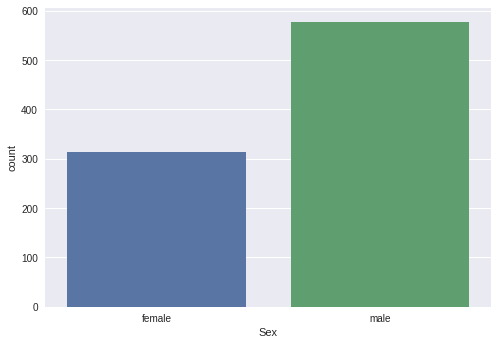

In [45]:
sns.countplot(x='Sex', data=titanic);

From this we can easily see that there were more male passengers than female ones. So, **Women and children first**? Let's have a look:

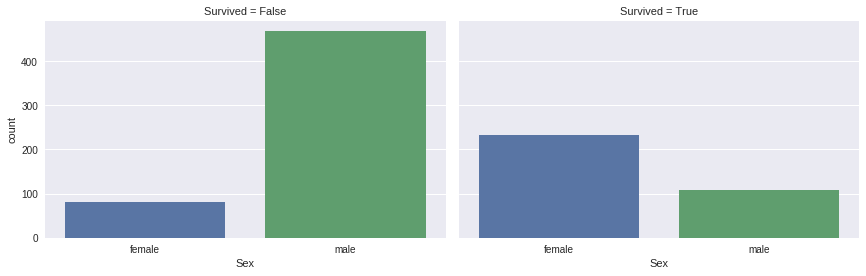

In [46]:
sns.factorplot(x='Sex', col='Survived', data=titanic, kind='count', size=4, aspect=1.5);

Clearly, more women survived the Titanic disaster than men did, and vastly more men died that night. What about the **Childrens first** part?

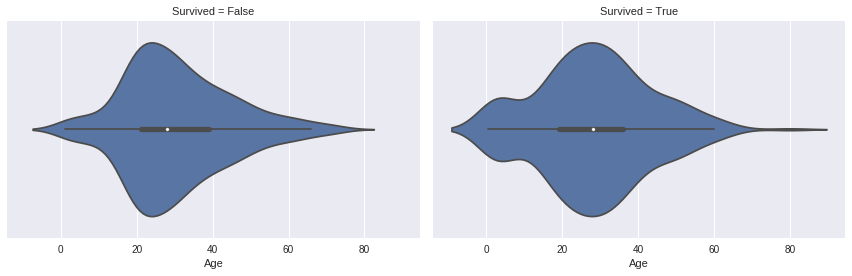

In [47]:
sns.factorplot(x='Age', col='Survived', data=titanic, kind='violin', size=4, aspect=1.5);

While the median of both distributions appear to be around the `25-30` years marker, the density of the distribution of survivors is significantly extended around the `0-10` years area.

Looking at the statistics of children younger than 14 years (there is at least one case of a 14 year old married woman in the dataset), we find that 42 children survived the event, with an average age of about four years.

In [48]:
childhood_threshold = 14
titanic[(titanic['Survived'] == True) & (titanic['Age'] < childhood_threshold)]['Age'].describe()

count    42.000000
mean      4.313571
std       3.528576
min       0.420000
25%       1.000000
50%       4.000000
75%       5.750000
max      13.000000
Name: Age, dtype: float64

However, 29 children did not survive the Titanic.

In [49]:
titanic[(titanic['Survived'] == False) & (titanic['Age'] < childhood_threshold)]['Age'].describe()

count    29.00000
mean      6.00000
std       3.55568
min       1.00000
25%       2.00000
50%       7.00000
75%       9.00000
max      11.00000
Name: Age, dtype: float64

So what influence did the ticket class have on the survival? Let's look at sex (along the rows), survivorship (along the columns) and ticket class (the separate series) and relate it to the age of the passenger.

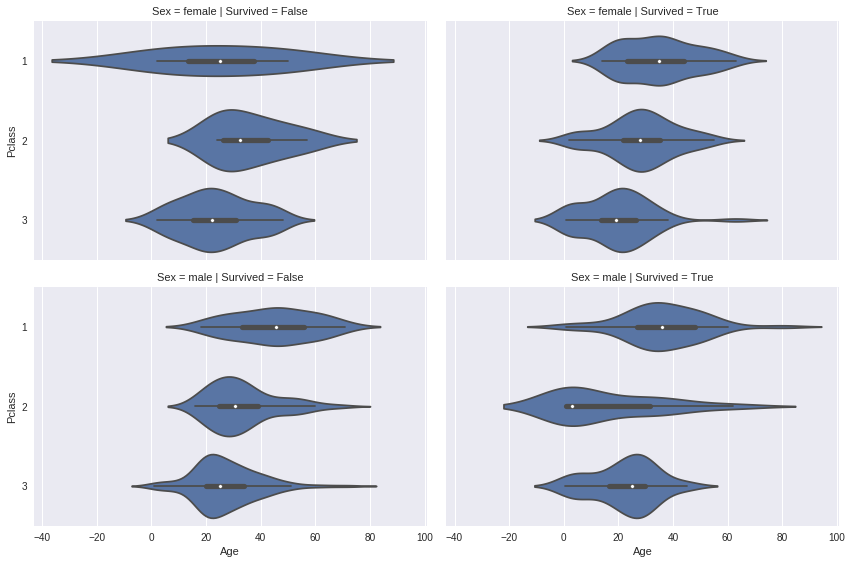

In [50]:
g = sns.FacetGrid(titanic, col='Survived', row='Sex', size=4, aspect=1.5)
g.map(sns.violinplot, 'Age', 'Pclass')

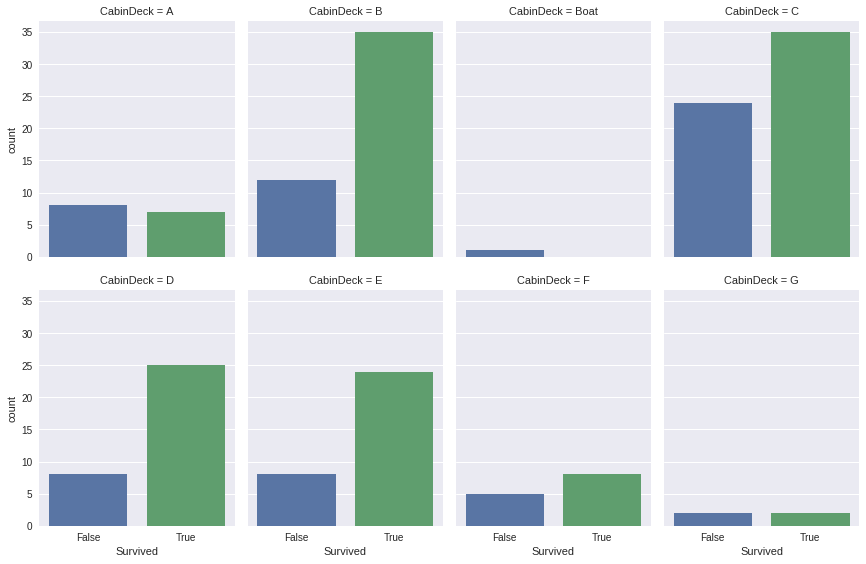

In [51]:
sns.factorplot('Survived', col='CabinDeck', col_wrap=4,
               data=titanic,
               kind='count', size=4, aspect=.75);

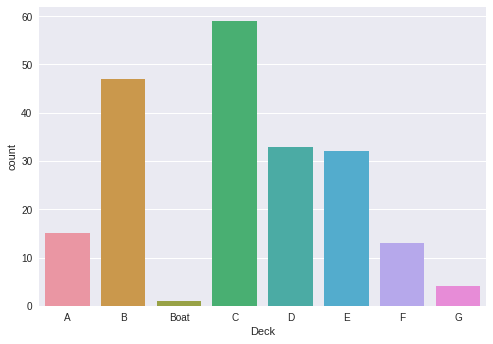

In [52]:
sns.countplot(x='CabinDeck', data=titanic)
plt.xlabel('Deck');

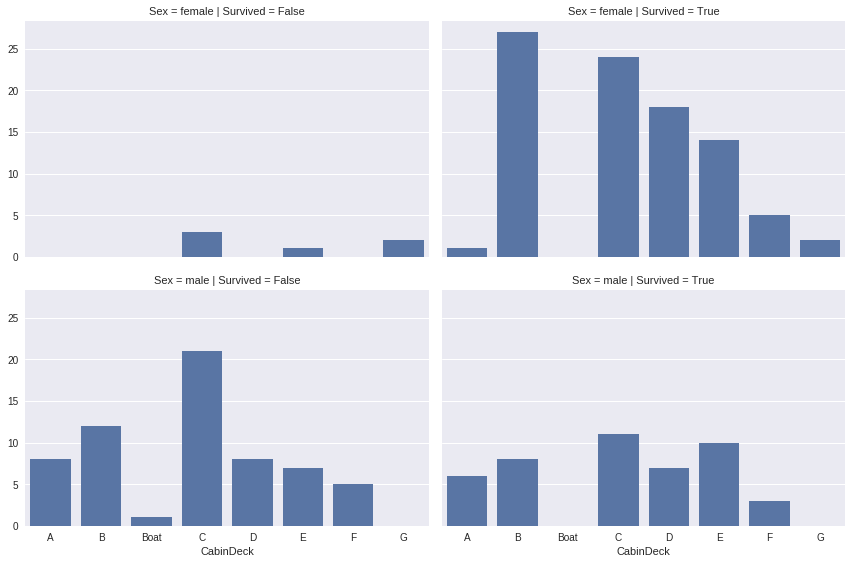

In [53]:
g = sns.FacetGrid(titanic, col='Survived', row='Sex', size=4, aspect=1.5)
g.map(sns.countplot, 'CabinDeck');

Even more clearly, about five times the number in men did not survive.

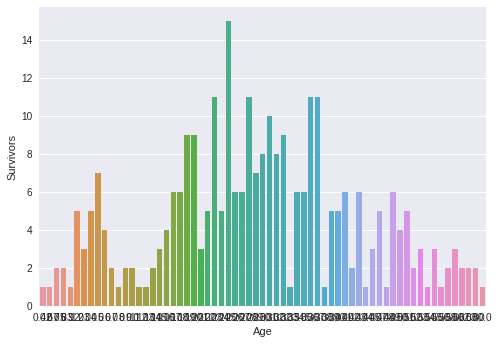

In [54]:
sns.countplot(x='Age', data=titanic[titanic['Survived'] == True])
plt.ylabel('Survivors');

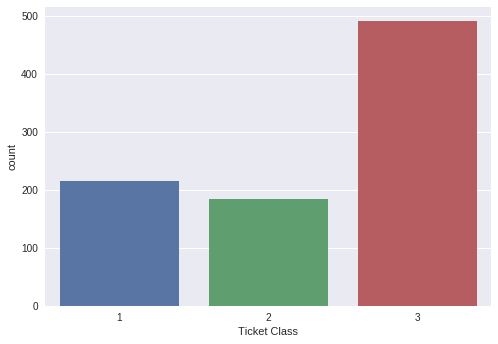

In [55]:
sns.countplot(x='Pclass', data=titanic)
plt.xlabel('Ticket Class');

Let's have a look at the ticket prices per class.

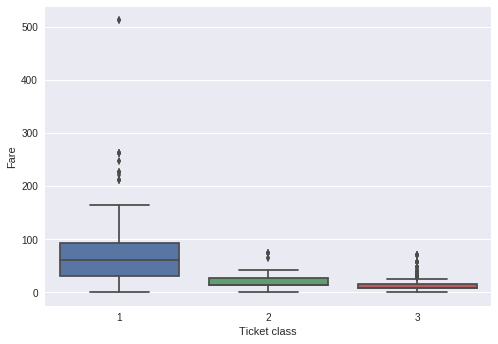

In [56]:
sns.boxplot(x='Pclass', data=titanic, y='Fare')
plt.xlabel('Ticket class');

There appear to be major outliers in the first class, which we will investigate in a second. It's also interesting to see that some tickets in the third class exceeded the price of regular second class tickets and also lied well withing the IQR of the first class tickets.

In [57]:
titanic['FirstName'].value_counts()

Mr. James                                       7
Mr. John                                        7
Miss. Mary                                      6
Mr. William                                     6
Miss. Bertha                                    4
Mr. William Henry                               4
Mr. William John                                4
Mr. Ivan                                        4
Mr. Victor                                      3
Mr. Samuel                                      3
Miss. Anna Sofia                                3
Mr. Tannous                                     3
Mr. George                                      3
Mr. Patrick                                     3
Mr. Martin                                      3
Miss. Anna                                      3
Mr. Edward                                      2
Mr. Michael                                     2
Mr. Alexander                                   2
Mr. Charles H                                   2


In [58]:
titanic[titanic['FirstName'] == 'Miss. Ellen "Nellie"']

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,LastName,FirstName,MarriedWoman,TicketNumber,TicketPrefix,CabinDeck,NumCabins,CabinsStarboard
PassengerId,,,,,,,,,,,,,,,,,
29,True,3,female,NaN,0,0,7.8792,NaN,Q,O'Dwyer,"Miss. Ellen ""Nellie""",False,330959,,NaN,NaN,NaN
291,True,1,female,26.0,0,0,78.8500,NaN,S,Barber,"Miss. Ellen ""Nellie""",False,19877,,NaN,NaN,NaN


In [59]:
titanic['LastName'].value_counts()

Andersson          9
Sage               7
Panula             6
Carter             6
Goodwin            6
Johnson            6
Skoog              6
Rice               5
Asplund            4
Hart               4
Lefebre            4
Harper             4
Ford               4
Harris             4
Williams           4
Smith              4
Palsson            4
Brown              4
Baclini            4
Kelly              4
Fortune            4
Gustafsson         4
Boulos             3
Thayer             3
Hansen             3
Van Impe           3
Jussila            3
Vander Planke      3
Jensen             3
Flynn              3
                  ..
Kirkland           1
Sinkkonen          1
Vander Cruyssen    1
Appleton           1
Widener            1
Mitchell           1
Frost              1
Henry              1
Mineff             1
Mockler            1
Partner            1
Cherry             1
Markoff            1
Smart              1
Vovk               1
Blank              1
Cardeza      